# Competição ML @SBS/DAA - 5ª Edição (2022/2023)

Esta competição está relacionada com o Trabalho Prático de Grupo das UCs do perfil Machine Learning: Fundamentos e Aplicações da Uminho e da UC Dados e Aprendizagem Automática, tendo, como destinatários, alunos do Mestrado em Engenharia Informática, do Mestrado em Matemática e Computação, e do Mestrado em Engenharia de Sistemas.

# Descrição da Competição
A previsão da quantidade de incidentes rodoviários é um conhecido problema de características estocásticas, não-lineares. Tem, contudo, aparecido na literatura um conjunto de modelos que demonstram um potencial assinalável neste tipo de previsões. Com isso em consideração, foi construído um dataset que contém dados referentes à quantidade e características dos incidentes rodoviários que ocorreram na cidade de Guimarães em 2021 (o dataset cobre um período que vai desde o dia 01 de Janeiro de 2021 até ao dia 31 de Dezembro do mesmo ano).

Com esta competição espera-se que os alunos desenvolvam e otimizem modelos de Machine Learning que sejam capazes de prever o número de incidentes rodoviários que irão acontecer na cidade de Guimarães a uma determinada hora.

## Imports utilizados

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# matplotlib inline

# Instalar as dependências necessárias

In [2]:
!pip install holidays
!pip3 install scipy

### Mudar o modo que a Interactive shell imprime as variáveis

In [3]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## Carregar os dataset de treino e de teste

In [4]:
TRAINING_DATASET_SOURCE = 'training_data.csv'
TEST_DATASET_SOURCE = 'test_data.csv'

In [5]:
train_df = pd.read_csv(TRAINING_DATASET_SOURCE)
test_df = pd.read_csv(TEST_DATASET_SOURCE)

#### Seed utilizada

In [6]:
SEED = 101

## Preparação de Dados

In [7]:
# Não tratar outliers de 'affected_roads', 'hour', 'day', 'month', 'weekday', 'weekend', 'holiday'
numeric_columns = ['avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed', 'luminosity']

### Converter features categóricas para valores numéricos

In [8]:
categorical_to_numerical = {
    'luminosity': {
        'LOW_LIGHT': 0,
        'LIGHT': 1,
        'DARK': 2
    }
}

In [9]:
from pandas import DataFrame
from sklearn.preprocessing import KBinsDiscretizer
import statistics
import holidays

dropped_columns = ['city_name','avg_precipitation', 'magnitude_of_delay']

# noinspection PyPep8Naming
def decision_tree_data_preparation(df: DataFrame) -> DataFrame:
    prep_df = df.drop(dropped_columns, axis=1)

    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Agrupar em 2 bins a feature 'avg_rain'
    prep_df.loc[prep_df['avg_rain'] == 'Sem Chuva', 'rain_level'] = 0
    prep_df.loc[prep_df['avg_rain'] != 'Sem Chuva', 'rain_level'] = 1

    prep_df.drop(columns=['avg_rain'], inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['record_date'])

    prep_df['hour'] = record_date.hour
    prep_df['day'] = record_date.day
    prep_df['month'] = record_date.month
    prep_df['weekday'] = record_date.weekday
    
    ### Verificar se a data se refere a um dia de fim-de-semana ou não.
    weekend = []
    for weekday in prep_df['weekday']:
        if weekday == 5 or weekday == 6:
            weekend.append(1)
        else:
            weekend.append(0)
    prep_df['weekend'] = weekend

    ### Criar 5 bins para a feature 'hour' consoante as horas do dia e a sua quantidade de tráfego.
    def hour_of_the_day(hour):
        if hour == 24 or 0 < hour < 8:
            return 1
        elif 8 <= hour < 12:
            return 2
        elif 12 <= hour < 16:
            return 3
        elif 16 <= hour < 20:
            return 4
        else:
            return 5

    prep_df["hour"] = prep_df["hour"].apply(hour_of_the_day)

    ### Verificar se a data se refere a um feriado português.
    portugueseHolidays = holidays.Portugal()

    def is_it_holiday(date_time):
        if date_time in portugueseHolidays:
            return 1
        else:
            return 0

    prep_df["holiday"] = prep_df["record_date"].apply(is_it_holiday)
    
    prep_df.drop(columns=['record_date'], inplace=True)

    ### Quantificar a feature 'affected_roads' para o número único de estradas afetadas
    # road_quantity = []
    valid_roads = []
    i = 0
    for line in prep_df['affected_roads']:
        unique_roads = set(str(line).split(','))
        for road in unique_roads:
            if (road not in valid_roads) & (road != ''):
                valid_roads.append(road)
                prep_df[f'{road}'] = [0] * len(prep_df)
                prep_df[f'{road}'][i] = 1     # 1 significa que essa rua foi afetada
            elif (road in valid_roads) & (road != ''):
                prep_df[f'{road}'][i] = 1     # 1 significa que essa rua foi afetada
            else:
                pass
        i+=1
        # valid_roads_row = [elem for elem in unique_roads if elem != '']
        # count = len(valid_roads_row)
        # road_quantity.append(count)
    """
    ### Substituir os missing values pela moda
    mode = statistics.mode(road_quantity)
    i = 0
    for quant in road_quantity:
        if quant == 0:
            road_quantity[i] = mode
        i = i + 1
    prep_df['affected_roads'] = road_quantity
    """
    #prep_df['quant_affected_roads'] = road_quantity
    ### Ao analisar o resultado pós-tratamento, verificámos que a feature 'affected_roads' tinha alta correlação com 'delay_in_minutes'
    prep_df.drop(columns=['affected_roads'], inplace=True)
    prep_df.drop(columns=['nan'], inplace=True)

    ### Converter a feature 'delay_in_seconds' para 'delay_in_minutes' de modo a reduzir o intervalo de valores
    delay_in_minutes = []
    for seconds in prep_df['delay_in_seconds']:
        minutes = seconds / 60
        delay_in_minutes.append(minutes)

    prep_df.drop(columns=['delay_in_seconds'], inplace=True)
    prep_df['delay_in_minutes'] = delay_in_minutes

    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))
    
    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    i = 0
    for num in numeric_columns:
        median = np.median(prep_df[num])
        prep_df.loc[prep_df[num] <= whiskers[i][1], num] = median
        prep_df.loc[prep_df[num] >= whiskers[i][2], num] = median
        i = i + 1
        
    return prep_df

### Divisão do dataset de treino em dados de treino e de teste

In [17]:
from sklearn.model_selection import train_test_split

X = decision_tree_data_preparation(train_df)
X
y = X['incidents']

X.drop(columns=['incidents'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

/var/folders/8y/y36_lcmn0tq020nptms4sypw0000gn/T/ipykernel_35027/2535351434.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_df[f'{road}'][i] = 1     # 1 significa que essa rua foi afetada
/var/folders/8y/y36_lcmn0tq020nptms4sypw0000gn/T/ipykernel_35027/2535351434.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_df[f'{road}'][i] = 1     # 1 significa que essa rua foi afetada
/var/folders/8y/y36_lcmn0tq020nptms4sypw0000gn/T/ipykernel_35027/2535351434.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,incidents,rain_level,hour,day,month,...,R206,N105,N309,N206,IC5,N310,N207-4,IC5 - N206,EM579,delay_in_minutes
0,2,12.0,1013.0,70.0,1.0,None,0.0,5,15,3,...,0,0,0,0,0,0,0,0,0,0.000000
1,2,12.0,1007.0,91.0,1.0,None,0.0,4,25,12,...,0,0,0,0,0,0,0,0,0,6.416667
2,1,14.0,1025.0,64.0,0.0,Low,0.0,3,12,3,...,0,0,0,0,0,0,0,0,0,1.150000
3,1,15.0,1028.0,75.0,1.0,Very_High,0.0,2,29,9,...,1,1,0,0,0,0,0,0,0,38.283333
4,1,27.0,1020.0,52.0,1.0,High,0.0,2,13,6,...,0,0,0,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2,13.0,1021.0,56.0,0.0,High,0.0,5,13,4,...,0,0,0,0,0,0,0,0,0,0.000000
4996,1,19.0,1017.0,68.0,0.0,None,0.0,3,6,7,...,0,0,0,0,0,0,0,0,0,0.000000
4997,2,13.0,1023.0,47.0,2.0,None,0.0,1,18,3,...,0,0,0,0,0,0,0,0,0,0.000000
4998,2,12.0,1014.0,93.0,2.0,None,0.0,1,2,11,...,0,0,0,0,0,0,0,0,0,0.000000


### Modelo de Árvore de decisão

In [11]:
clf = DecisionTreeClassifier(random_state=SEED)

clf.fit(X_train, y_train)

scoresDT = cross_val_score(clf, X, y, cv=200)

"""
# Validação cruzada (K Fold)
from sklearn.svm import SVC

cross_valid_model = SVC(random_state=2021)
scoresSVC = cross_val_score(cross_valid_model, X, np.ravel(y), cv=2)

scoresSVC
"""
print("Accuracy de %0.2f com um desvio padrão de %0.2f" % (scoresDT.mean(), scoresDT.std()))

DecisionTreeClassifier(random_state=101)

'\n# Validação cruzada (K Fold)\nfrom sklearn.svm import SVC\n\ncross_valid_model = SVC(random_state=2021)\nscoresSVC = cross_val_score(cross_valid_model, X, np.ravel(y), cv=2)\n\nscoresSVC\n'

Accuracy de 0.91 com um desvio padrão de 0.05


#### Obter as previsões

In [12]:
predictions = clf.predict(X_test)

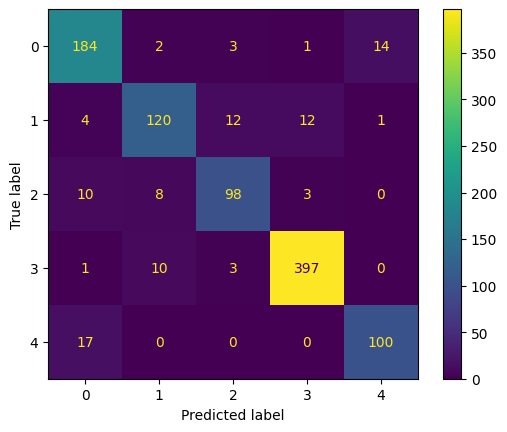

In [13]:
cm = confusion_matrix(y_test, predictions)
# TP FP
# FN TN
disp = ConfusionMatrixDisplay(cm)

disp.plot()

In [14]:
accuracy_score(y_test, predictions)
# (TP + TN) / (TP + FP + FN + TN)

precision_score(y_test, predictions, average='micro')
# TP / (TP + FP)

recall_score(y_test, predictions, average='micro')
# TP / (TP + FN)

0.899

0.899

0.899

# Reading the test dataset

In [15]:
X = decision_tree_data_preparation(test_df)

/var/folders/8y/y36_lcmn0tq020nptms4sypw0000gn/T/ipykernel_35027/2535351434.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_df[f'{road}'][i] = 1     # 1 significa que essa rua foi afetada
/var/folders/8y/y36_lcmn0tq020nptms4sypw0000gn/T/ipykernel_35027/2535351434.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_df[f'{road}'][i] = 1     # 1 significa que essa rua foi afetada
/var/folders/8y/y36_lcmn0tq020nptms4sypw0000gn/T/ipykernel_35027/2535351434.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

# Getting the predictions

In [16]:
predictions = clf.predict(X)

predictions_df = pd.DataFrame(predictions)

predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Incidents'], index_label='RowId')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- N101 - N310
Feature names seen at fit time, yet now missing:
- IC5 - N206

  warnings.warn(message, FutureWarning)
